In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

In [3]:
# Hyper param
epoch_num = 70
batch_size = 128
lr = 5e-3
class_num = 7

In [4]:
# Read data (48x48 pixel gray scale images)
# Dataset link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
train_dir = '../../data/emotion-detection-fer/train'
test_dir = '../../data/emotion-detection-fer/test'

transform  = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

train_dataset = datasets.ImageFolder(train_dir,transform=transform)
test_dataset = datasets.ImageFolder(test_dir,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


Text(0.5, 1.0, 'fearful')

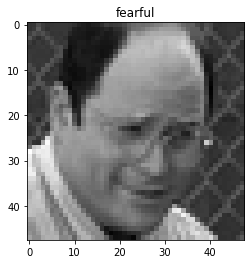

In [5]:
testdata = next(iter(train_loader))
pic = testdata[0][0]
label = testdata[1][0]

idx_to_class = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
plt.imshow(np.reshape(pic, pic.size()[1:]), cmap='gray')
plt.title(idx_to_class[label])

In [6]:
# Model
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.linear = nn.Linear(12 * 12 * 16, class_num)
        self.output = nn.Sigmoid()

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return self.output(out)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
torch.cuda.is_available()

True

In [8]:
loss_list = []
for epoch in range(epoch_num):
    for i, (pics, labels) in enumerate(tqdm(train_loader, colour='cyan', leave=False, desc=f'Epoch {epoch}/{epoch_num}', unit='batch')):
        pics = pics.to(device)
        labels = labels.to(device)
        output = model(pics)
        loss = criterion(output, labels)

        if (i + 1) % 100 == 0:
            loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
torch.cuda.empty_cache()

KeyboardInterrupt: 

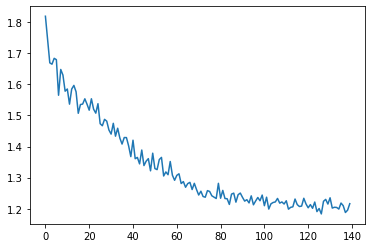

In [141]:
plt.plot(loss_list)

In [142]:
with torch.no_grad():
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct / total}')

Accuracy: 0.553496795764837


In [143]:
torch.save(model, 'model.ckpt')
torch.save(model.state_dict(), 'params.ckpt')

In [10]:
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[-0.0319, -0.3015, -0.0302],
                        [ 0.1486,  0.1437,  0.2287],
                        [-0.2256, -0.1025, -0.1350]]],
              
              
                      [[[-0.3156, -0.0757, -0.3017],
                        [-0.2730, -0.0947,  0.0176],
                        [ 0.0098, -0.1964,  0.1697]]],
              
              
                      [[[ 0.0521, -0.1657,  0.0309],
                        [-0.3077, -0.1959, -0.2564],
                        [ 0.2395,  0.1964, -0.1991]]],
              
              
                      [[[-0.0693, -0.2800,  0.1300],
                        [-0.0445,  0.0830, -0.2597],
                        [ 0.0665, -0.0558,  0.2794]]],
              
              
                      [[[ 0.0670,  0.2616, -0.1641],
                        [-0.0827, -0.1461,  0.2848],
                        [-0.3142, -0.0175,  0.2117]]],
              
              
            